In [1]:
from main import ChessDataset, mAP
import os
import torch
import numpy as np
from engine import train_one_epoch
import torchvision as tv
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm
import utils
import matplotlib.pyplot as plt

op = os.path
ROOT = 'data/train/'

In [2]:
ds = ChessDataset(ROOT)

model = tv.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
num_classes = 12

in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

100%|█████████████████████████████████████████████████████████████████████| 20/20 [06:30<00:00, 19.52s/it]


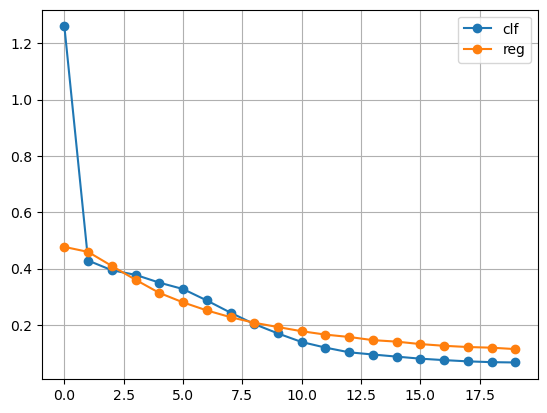

In [4]:
indices = torch.randperm(len(ds)).tolist()
ds_train = torch.utils.data.Subset(ds, indices[:120])
ds_test = torch.utils.data.Subset(ds, indices[120:])

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=1e-4, nesterov=True)

data_loader_train = torch.utils.data.DataLoader(
    ds_train, batch_size=4, shuffle=True, num_workers=4, collate_fn=utils.collate_fn
)
data_loader_test = torch.utils.data.DataLoader(
    ds_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=utils.collate_fn
)
num_epochs = 20

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
for epoch in tqdm(range(num_epochs)):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(
        model, optimizer, data_loader_train, device, epoch, print_freq=0
    )

In [189]:
_ = model.eval()

metrics = {}
for img, ann in tqdm(ds_test):
    pred = model([img.to(device)])[0]
    metrics[ann['id'].item()] = mAP(ann, pred)

import pandas as pd
from datetime import datetime
metrics = pd.Series(metrics)
metrics.to_csv(f'chess_iou_{datetime.now().isoformat()}'.csv)
print(metrics.mean())

100%|█████████████████████████████████████████████████████████████████████| 82/82 [00:08<00:00,  9.36it/s]
